# DSCI 100 Group Project Report (Group 17)
## Factors of Toxicity of Mushrooms (Chosen Data Set: Mushrooms)

In [2]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
set.seed(87)
data <- read_csv("https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv") %>%
        mutate(class=as.factor(class))
# to check the proportion of edible and poisonous mushrooms in the database
dataprop <- data %>% 
            select(class) %>%
            group_by(class) %>%
            summarize(n=n()) %>%
            mutate(prop = (100*n)/sum(n))
dataprop

Parsed with column specification:
cols(
  .default = col_character(),
  bruises = col_logical(),
  `gill-attachment` = col_logical()
)

See spec(...) for full column specifications.

Warning message:
“210 parsing failures.
 row             col           expected actual                                                                                     file
6039 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6041 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6376 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6425 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-100-Group-Project/master/mushrooms.csv'
6435 gill-attachment 1/0/T/F/TRUE/FALSE      a 'https://raw.githubusercontent.com/alexcw-5/DSCI-1

class,n,prop
<fct>,<int>,<dbl>
e,4208,51.79714
p,3916,48.20286


Warning message in warn_if_args_exist(list(...)):
“Extra arguments: 'cols' are being ignored.  If these are meant to be aesthetics, submit them using the 'mapping' variable within ggpairs with ggplot2::aes or ggplot2::aes_string.”


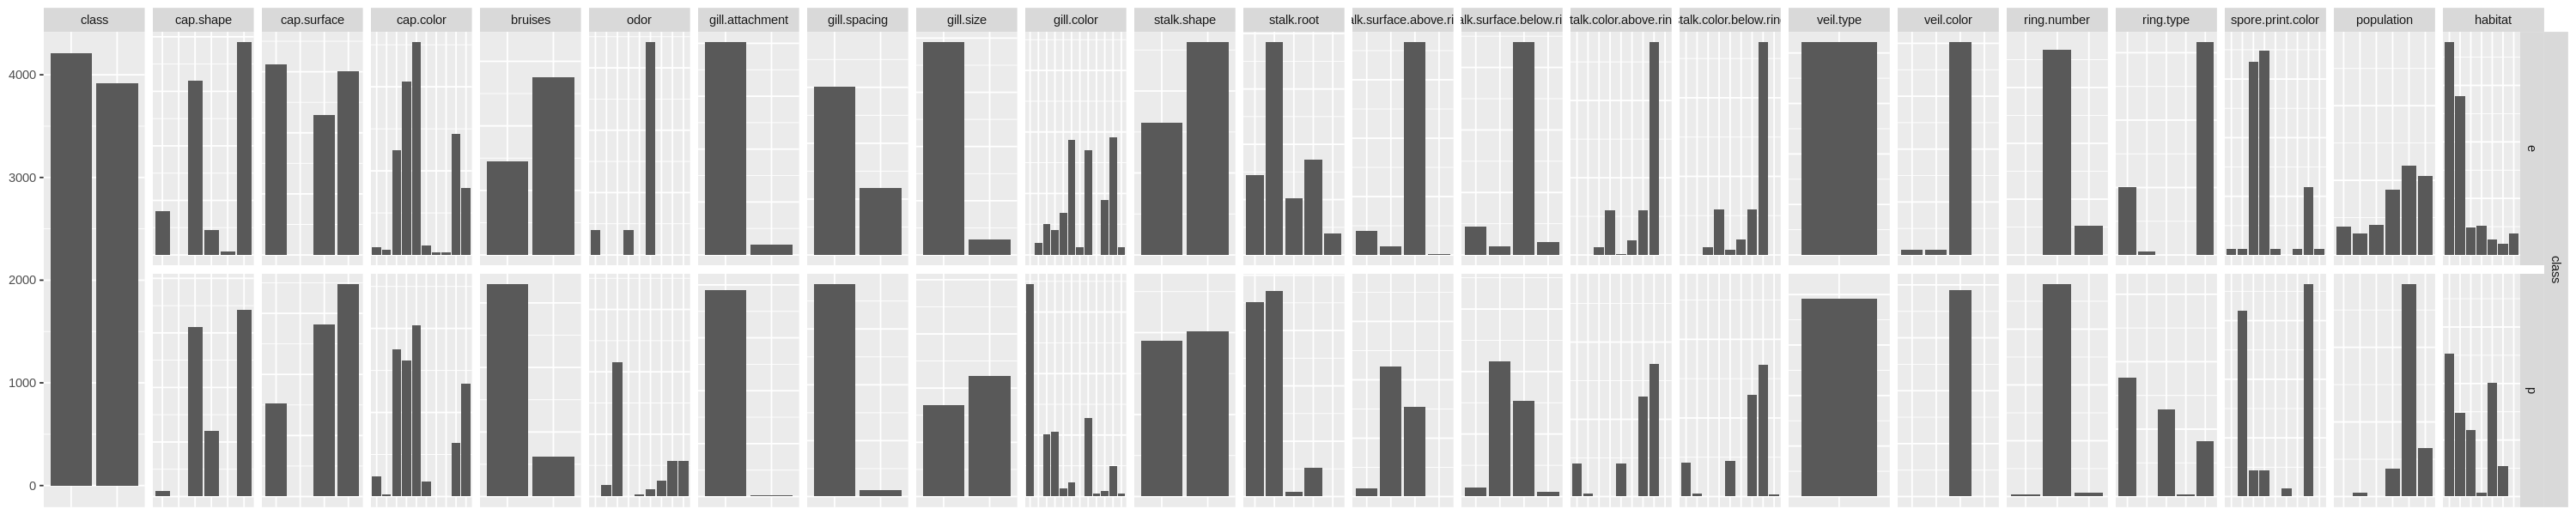

In [4]:
# to make the column names usable with ggplot and other commands, hyphens do not work
colnames(data) <- make.names(colnames(data))
filtered <- data %>% select(gill.color, ring.type, odor, stalk.color.below.ring, habitat, class)
# to make the column names usable with knn-classification
filtered$gill.color <- as.integer(as.factor(filtered$gill.color))
filtered$ring.type <- as.integer(as.factor(filtered$ring.type))
filtered$odor <- as.integer(as.factor(filtered$odor))
filtered$stalk.color.below.ring <- as.integer(as.factor(filtered$stalk.color.below.ring))
filtered$habitat <- as.integer(as.factor(filtered$habitat))
# splitting the database into training and testing datasets
split <- initial_split(filtered, prop = 0.75, Strata = class)
train <- training(split)
test <- testing(split)
options(repr.plot.width = 25, repr.plot.height = 5)
# to check for variables that have significant variability for poisonous and edible mushrooms
plot <- ggpairs(data, cols=1:23)
plot$plots = plot$plots[1:23]
plot$yAxisLabels = plot$yAxisLabels[1]
plot


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


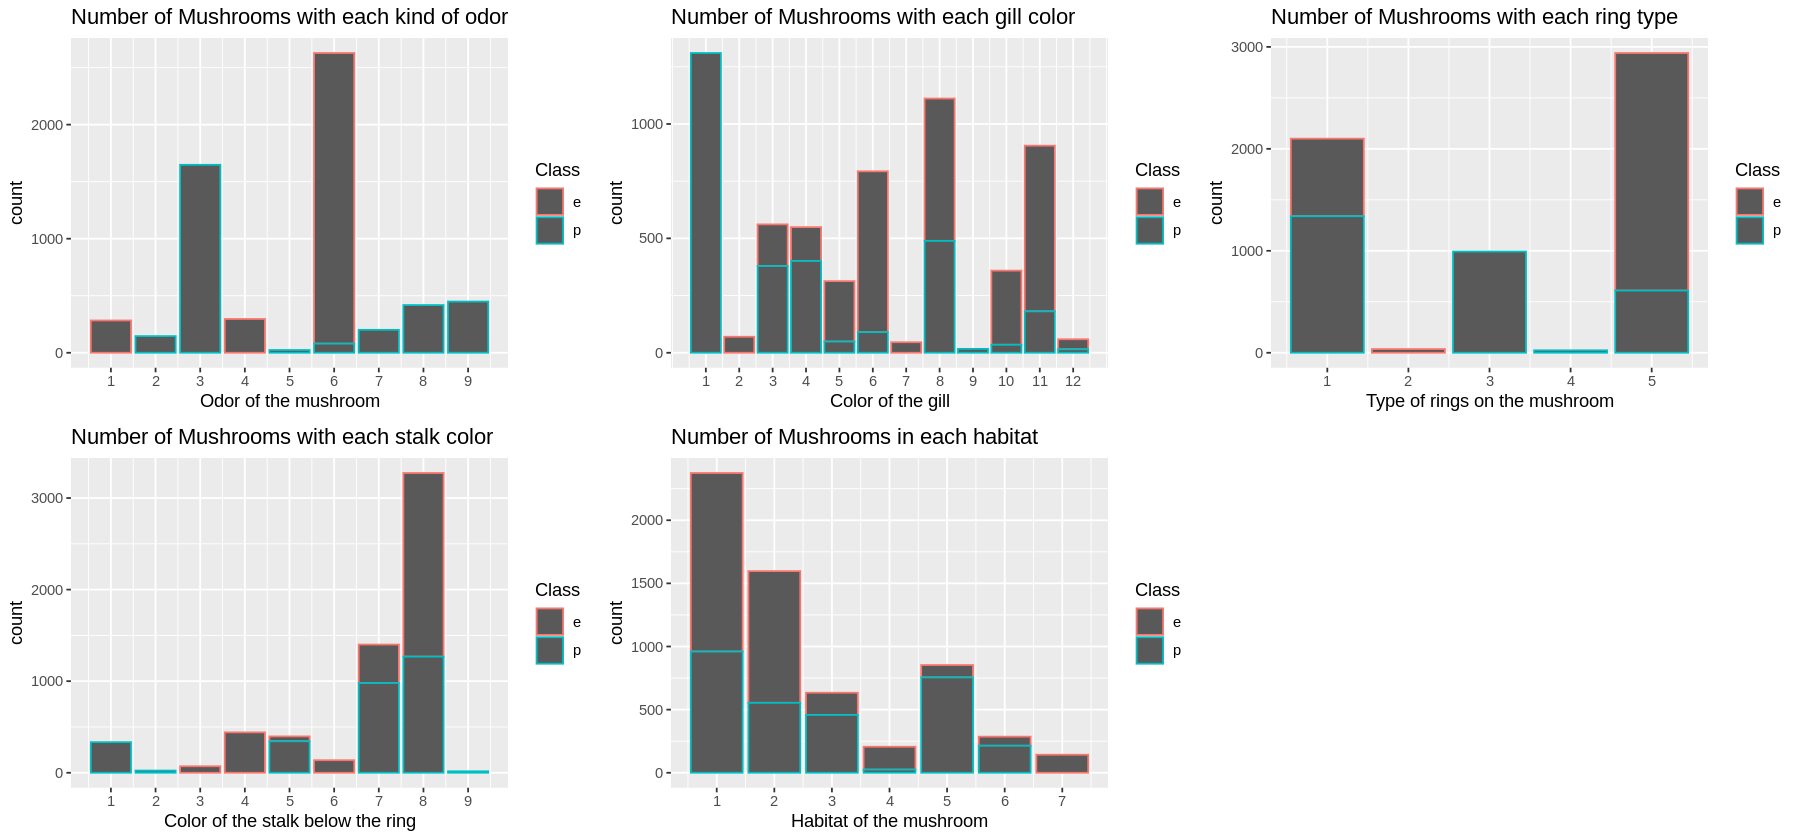

In [5]:
#to check the chosen variables variability with different classes
odor <- train %>% ggplot(aes(x=odor, color=class)) +
                    geom_histogram(stat="count") +
                    labs(x="Odor of the mushroom", color='Class') +
                    ggtitle("Number of Mushrooms with each kind of odor") +
                    scale_x_continuous(breaks = seq(1, 9, by = 1))
gill_color <- train %>% ggplot(aes(x=gill.color, color=class)) +
                        geom_histogram(stat="count") + 
                        labs(x="Color of the gill", color='Class') +
                        ggtitle("Number of Mushrooms with each gill color") +
                        scale_x_continuous(breaks = seq(1, 12, by = 1))
ring_type <- train %>% ggplot(aes(x=ring.type, color=class)) +
                        geom_histogram(stat="count") +
                        labs(x="Type of rings on the mushroom", color='Class') +
                        ggtitle("Number of Mushrooms with each ring type") +
                        scale_x_continuous(breaks = seq(1, 5, by = 1))
stalk_color_below_ring <- train %>% ggplot(aes(x=stalk.color.below.ring, color=class)) +
                                    geom_histogram(stat="count") +
                                    labs(x="Color of the stalk below the ring", color='Class') +
                                    ggtitle("Number of Mushrooms with each stalk color") +
                                    scale_x_continuous(breaks = seq(1, 9, by = 1))
habitat <- train %>% ggplot(aes(x=habitat, color=class)) +
                        geom_histogram(stat="count") +
                        labs(x="Habitat of the mushroom", color='Class') +
                        ggtitle("Number of Mushrooms in each habitat") +
                        scale_x_continuous(breaks = seq(1, 7, by = 1))
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(odor, gill_color, ring_type, stalk_color_below_ring, habitat)

In [ ]:
# creating the workflow of the model
ms_recipe <- recipe(class ~ gill.color + ring.type + odor + habitat + stalk.color.below.ring, data = train)

ms_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# we use 10 vfolds and not a value as low as 5 for example, as the training set has ~6k rows and each fold would be too large otherwise
ms_vfold <- vfold_cv(train, v = 10, strata = class)
# we use a large range of values as the number of data points in the dataset are ~6k, so small values may not cover enough of the dataset
vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

ms_workflow <- workflow() %>%
  add_recipe(ms_recipe) %>%
  add_model(ms_spec) %>%
  tune_grid(resamples = ms_vfold, grid = vals)

#to check how accurate the model is for values of k, 1 to 30
accuracy <- ms_workflow %>%
            collect_metrics() %>%
            filter(.metric=="accuracy")
accuracy

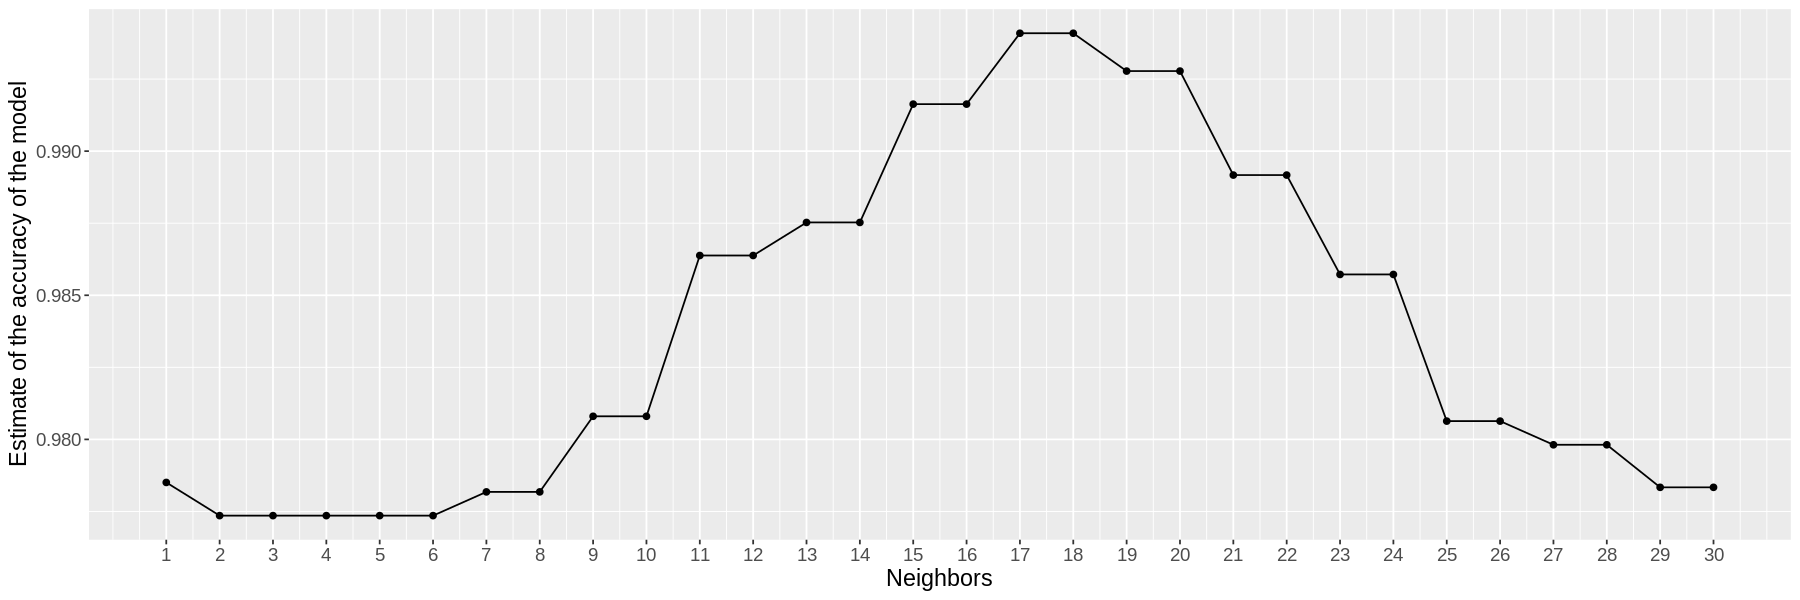

In [10]:
#to find which value of k results in the more accurate model
options(repr.plot.width = 15, repr.plot.height = 5)
compare_k_acc <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Estimate of the accuracy of the model") + 
  theme(text = element_text(size = 14)) +
  scale_x_continuous(breaks = seq(1, 30, by = 1))
compare_k_acc

In [12]:
#hence, we have the k that would result in the more accurate model, k=17
ms_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) %>%
  set_engine("kknn") %>%
  set_mode("classification")

ms_final_workflow <- workflow() %>%
  add_recipe(ms_recipe) %>%
  add_model(ms_final_spec) %>%
  fit(data = train)

#to test accuracy of the model against the testing set
ms_predictions <- predict(ms_final_workflow, test) %>%
  bind_cols(test) %>%
  mutate(class=as.factor(class))
ms_predict_test <- ms_predictions %>%
                   metrics(truth = class, estimate = .pred_class) %>%
                   filter(.metric == "accuracy")
ms_predict_test

#confusion matrix to see how many classifications the model did not get right in the testing set
confmat <- conf_mat(ms_predictions, truth = class, estimate = .pred_class)
confmat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9896603


          Truth
Prediction    e    p
         e 1081   21
         p    0  929

### Introduction

#### Background Information

From August through to November, mushrooms are a common sight to see in Canada. Be it deep in the forests of Quebec, or right in the backyard of your home in BC, mushrooms can be found everywhere. But although some may appear to be harmless, upon ingestion, many types of mushrooms may prove to cause various harmful symptoms to the human body. As a result, classification of mushrooms into either edible or poisonous is an extremely significant step for mushroom foragers around the globe. Using multivariable K- Nearest Neighbors classification of the dataset, our goal is to answer the following predictive question: What factors are good predictors of mushroom edibility? KNN classification is suitable for this problem because we desire to form a classifier using multiple characteristics of the mushrooms with a known class to predict if mushrooms without a class are either edible or poisonous for consumption.

### Methodology

Our project goal is to build a predictive model, using the K-Nearest Neighbors Classification algorithm, to determine if a mushroom is edible or poisonous. To do so, we used {insert attributes here} to compute the distance between unseen data points and the K-closest data points. Once we have identified the closest neighbors, we can assign the label that appears the most often in the set of K neighbors to the unseen data point. This algorithm is appropriate for our question because often, mushrooms with similar attributes can be similarly classified as either edible or poisonous. 

We chose to drop some of the attributes from the data set because some of them are very similar to each other, and we wanted to lower the computational time and reduce unnecessary complexity of the algorithm. 

For the initial split of our dataset, we split our data so that 75% was in the training set and 25% was in the testing set. We intuitively chose this because we felt that it was a good ratio in which the model would not be underfit or overfit, while still leaving enough data remaining to use when testing our model. Additionally, it was mentioned in textbook section 6.5.1 that generally, the amount of data that goes in the training set is between 50% and  95%, so as a result, we felt that 75% was a good midpoint between these values. 


### Results

text here

### Discussion

text here

***
## Appendix

#### Bibliography

* text here